In [ ]:
!pip install -U accelerate

In [ ]:
!pip install transformers datasets evaluate rouge_score
# !pip install datasets evaluate rouge_score

In [ ]:
!pip install py7zr

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import pipeline, set_seed, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import nltk
import numpy as np
import torch

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 0 if torch.cuda.is_available() else -1

# Load dataset

In [ ]:
samsung_corpus = load_dataset("samsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
samsung_corpus

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
train_ds = samsung_corpus['train']

# 2 Exploratory Data Analysis

## a Dataset Exploration

In [ ]:
train_ds

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})

In [ ]:
for i in range(5):
  print(f'------ Dialogue {i+1} ------ ')
  print(train_ds['dialogue'][i])
  print(f'------ Summary {i+1} ------')
  print(train_ds['summary'][i])
  print()


------ Dialogue 1 ------ 
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
------ Summary 1 ------
Amanda baked cookies and will bring Jerry some tomorrow.

------ Dialogue 2 ------ 
Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
------ Summary 2 ------
Olivia and Olivier are voting for liberals in this election. 

------ Dialogue 3 ------ 
Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
------ Summary 3 ------
Kim may

In [ ]:
train_ds['summary'][:5]

['Amanda baked cookies and will bring Jerry some tomorrow.',
 'Olivia and Olivier are voting for liberals in this election. ',
 'Kim may try the pomodoro technique recommended by Tim to get more stuff done.',
 'Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside. ',
 'Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do.']

The dataset contains dialogues that are small day-to-day conversations between two people, along with their summaries.

## b Length distribution of dialogues and summaries in the training set

In [ ]:
def add_length_distribution(example):
  return {'dialogue_length': len(example['dialogue'].split()),
          'summary_length': len(example['summary'].split())}

In [ ]:
updated_train_ds = train_ds.map(add_length_distribution)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

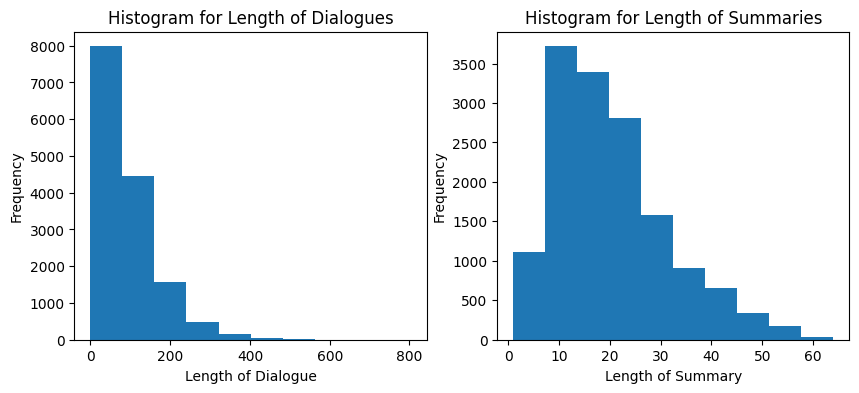

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].hist(updated_train_ds['dialogue_length'])
ax[0].set_xlabel('Length of Dialogue')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram for Length of Dialogues')

ax[1].hist(updated_train_ds['summary_length'])
ax[1].set_xlabel('Length of Summary')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram for Length of Summaries')
plt.show();

## c 20 most common words in the dialogues

In [ ]:
def get_all_word_freq(examples):
  word_freq = {}
  for diag in examples['dialogue']:
    for word in diag.split():
      if word not in word_freq:
        word_freq[word] = 0
      word_freq[word] += 1

  return word_freq

In [ ]:
word_freq = get_all_word_freq(updated_train_ds)

In [ ]:
top_20_words = {k: v for k, v in sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:20]}

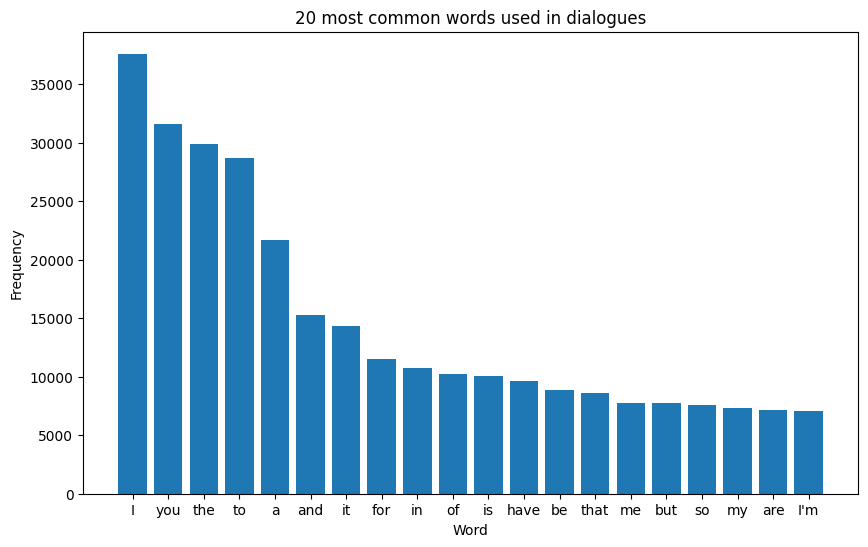

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(list(top_20_words.keys()), list(top_20_words.values()))
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('20 most common words used in dialogues')
plt.show();

# 3 Inference with Pre-trained Models

In [ ]:
def pretrained_summary(model_name, examples, prefix="", suffix="", max_length=None):
  '''
  Function to get summaries from specified pre-trained model.
  Prefix and suffix can be added to each dialogue depending upon the model used
  '''
  set_seed(42)
  summarizer = pipeline("summarization", model=model_name)

  result = {}
  result['dialogue'] = [example['dialogue'] for example in examples]

  if max_length:
    result['summary'] = [summarizer(prefix + example['dialogue'] + suffix, max_length=max_length) for example in examples]
  else:
    result['summary'] = [summarizer(prefix + example['dialogue'] + suffix) for example in examples]

  return result

In [ ]:
examples = samsung_corpus['test'].take(3)

In [ ]:
def print_dialogue_with_summary(examples):
  for i in range(len(examples['dialogue'])):
    print(f'------------------ Dialogue ---------------')
    print(examples['dialogue'][i])
    print(f'------------------ Summary ---------------')
    print(examples['summary'][i][0]['summary_text'])
    print()

## bart-large-cnn

In [ ]:
bart_pretrained = 'facebook/bart-large-cnn'

In [ ]:
bart_pretrained_summ = pretrained_summary(bart_pretrained, examples)

Your max_length is set to 142, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


In [ ]:
bart_pretrained_summ

{'dialogue': ["Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",
  "Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :)",
  "Lenny: Babe, can you help me with something?\r\nBob: Sure, what

In [ ]:
print_dialogue_with_summary(bart_pretrained_summ)

------------------ Dialogue ---------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
------------------ Summary ---------------
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry. Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it a day and says she's going to go home. Hannah: "Bye bye"

------------------ Dialogue ---------------
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only sta

## T5-large

In [ ]:
t5_pretrained = 't5-large'

In [ ]:
t5_pretrained_summ = pretrained_summary(t5_pretrained, examples)

Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)
Your max_length is set to 200, but your input_length is only 196. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=98)


In [ ]:
print_dialogue_with_summary(t5_pretrained_summ)

------------------ Dialogue ---------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
------------------ Summary ---------------
Hannah: hey, do you have Betty's number? Amanda: ask Larry Amanda: he called her last time we were at the park together Hannah: don't be shy, he's very nice .

------------------ Dialogue ---------------
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no!

## gpt2-large

In [ ]:
gpt2_pretrained = 'gpt2-large'

In [ ]:
gpt2_pretrained_summ = pretrained_summary(gpt2_pretrained, examples, suffix="\nTL;DR:", max_length=250)

The model 'GPT2LMHeadModel' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].
Your max_length is set to 250, but your input_length is only 143.

In [ ]:
print_dialogue_with_summary(gpt2_pretrained_summ)

------------------ Dialogue ---------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
------------------ Summary ---------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
TL;DR: I'm not sure if I should be happy or sad about this.
Hannah: I'm not sure if I should be h

## Inference

*   The summaries produced by the BART and T5 models are coherent and capture the main points of the conversation, but they introduce some inconsistencies. The generated summaries are mostly comprised of the dialogues.

*   The summaries produced by GPT-2 models aren't coherent. Due to the absence of an encoder, the model is unable to learn information from the dialogue, thus producing unrelated text.



# 4 Fine-tuning

## a Selecting model for fine-tuning

In [ ]:
model_checkpoint = 'facebook/bart-large-cnn'

## b Tokenizing dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    # Tokenize the dialogues (input)
    model_inputs = tokenizer(examples['dialogue'], max_length=max_input_length, truncation=True)

    # Tokenize the targets (summary)
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = samsung_corpus.map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

## c Training Model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
required_batch_size = 8
actual_batch_size = required_batch_size // 2
gradient_accumulation_steps = actual_batch_size

model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size= actual_batch_size,
    gradient_accumulation_steps= gradient_accumulation_steps,
    gradient_checkpointing=True,
    per_device_eval_batch_size= actual_batch_size,
    # per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def get_rouge_bleu(predictions, references):
  rouge_metric = evaluate.load("rouge")
  bleu_metric = evaluate.load("bleu")

  result = rouge_metric.compute(predictions=predictions, references=references, use_stemmer=True, use_aggregator=True)
  result['bleu'] = bleu_metric.compute(predictions=predictions, references=references)['bleu']
  return result

In [ ]:
def compute_metrics(eval_pred):

  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  # Replace -100 in the labels as we can't decode them.
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

  result = get_rouge_bleu(decoded_preds, decoded_labels)

  # Add mean generated length
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# empty the cache before training to avoid memory issues
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  13867 MiB |  14030 MiB |  10373 GiB |  10359 GiB |
|       from large pool |  13852 MiB |  14012 MiB |   8724 GiB |   8710 GiB |
|       from small pool |     15 MiB |     75 MiB |   1648 GiB |   1648 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  13867 MiB |  14030 MiB |  10373 GiB |  10359 GiB |
|       from large pool |  13852 MiB |  14012 MiB |   8724 GiB |

In [ ]:
pretrained_val_output = trainer.predict(tokenized_datasets["validation"])
pretrained_val_output.metrics

{'test_loss': 2.155902147293091,
 'test_rouge1': 0.3151,
 'test_rouge2': 0.1102,
 'test_rougeL': 0.2388,
 'test_rougeLsum': 0.2952,
 'test_bleu': 0.0538,
 'test_gen_len': 66.1271,
 'test_runtime': 403.0437,
 'test_samples_per_second': 2.03,
 'test_steps_per_second': 0.509}

In [ ]:
pretrained_test_output = trainer.predict(tokenized_datasets["test"])
pretrained_test_output.metrics

{'test_loss': 2.192270517349243,
 'test_rouge1': 0.3075,
 'test_rouge2': 0.1026,
 'test_rougeL': 0.231,
 'test_rougeLsum': 0.2866,
 'test_bleu': 0.0485,
 'test_gen_len': 66.6813,
 'test_runtime': 443.0008,
 'test_samples_per_second': 1.849,
 'test_steps_per_second': 0.117}

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len
0,1.399300,1.360007,0.428400,0.221100,0.332100,0.397300,0.132200,59.658900


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=920, training_loss=1.3601395316745923, metrics={'train_runtime': 2917.2853, 'train_samples_per_second': 5.05, 'train_steps_per_second': 0.315, 'total_flos': 8823027777404928.0, 'train_loss': 1.3601395316745923, 'epoch': 0.9991854466467553})

## d Fine-tuning results on validation dataset

In [ ]:
finetuned_preds_output = trainer.predict(tokenized_datasets["validation"])
finetuned_preds_output.metrics

{'test_loss': 1.3600070476531982,
 'test_rouge1': 0.4284,
 'test_rouge2': 0.2211,
 'test_rougeL': 0.3321,
 'test_rougeLsum': 0.3973,
 'test_bleu': 0.1322,
 'test_gen_len': 59.6589,
 'test_runtime': 349.6808,
 'test_samples_per_second': 2.339,
 'test_steps_per_second': 0.586}

# 5 Evaluation and Analysis

## a Evaluating fine-tuned and pre-trained results

In [ ]:
finetuned_test_output = trainer.predict(tokenized_datasets["test"])
finetuned_test_output.metrics

{'test_loss': 1.3850183486938477,
 'test_rouge1': 0.4153,
 'test_rouge2': 0.2116,
 'test_rougeL': 0.3207,
 'test_rougeLsum': 0.3867,
 'test_bleu': 0.1262,
 'test_gen_len': 59.768,
 'test_runtime': 355.185,
 'test_samples_per_second': 2.306,
 'test_steps_per_second': 0.577}

In [ ]:
finetuned_test_output

PredictionOutput(predictions=array([[2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       ...,
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1]]), label_ids=array([[    0,   725, 25984, ...,     1,     1,     1],
       [    0, 24375,     8, ...,     1,     1,     1],
       [    0,   574, 11867, ...,     1,     1,     1],
       ...,
       [    0, 13012,   102, ...,     1,     1,     1],
       [    0,   970,    21, ...,     1,     1,     1],
       [    0, 41415, 11210, ...,     1,     1,     1]]), metrics={'test_loss': 1.3850183486938477, 'test_rouge1': 0.4153, 'test_rouge2': 0.2116, 'test_rougeL': 0.3207, 'test_rougeLsum': 0.3867, 'test_bleu': 0.1262, 'test_gen_len': 59.768, 'test_runtime': 355.185, 'test_samples_per_second': 2.306, 'test_steps_per_second': 0.577})

### Get pre-trained test results

In [ ]:
bart_pretrained

'facebook/bart-large-cnn'

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

pretrained_pipe = pipeline("summarization", model=bart_pretrained, device=device)

In [ ]:
KeyDataset(examples, 'dialogue')

In [ ]:
pretrained_pipeline_test_results = []
for out in tqdm(pretrained_pipe(KeyDataset(samsung_corpus['test'], "dialogue"))):
  pretrained_pipeline_test_results.append(out[0]['summary_text'])
  # print(out)

  0%|          | 0/819 [00:00<?, ?it/s]

Your max_length is set to 142, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)
Your max_length is set to 142, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 142, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 142, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


In [ ]:
pretrained_test_results = get_rouge_bleu(pretrained_pipeline_test_results, samsung_corpus['test']['summary'])

In [ ]:
pretrained_test_results

{'rouge1': 0.3143053033186602,
 'rouge2': 0.1076220697857603,
 'rougeL': 0.2314921552241609,
 'rougeLsum': 0.23140149971919413,
 'bleu': 0.05398783297929854}

Comparing the metrics for pre-trained and fine-tuned model, it can be deduced that fine tuning helps achieve better results.

## b Analyzing fine-tuned and pre-trained summaries.

In [ ]:
finetuned_test_output

PredictionOutput(predictions=array([[2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       ...,
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1],
       [2, 0, 0, ..., 1, 1, 1]]), label_ids=array([[    0,   725, 25984, ...,     1,     1,     1],
       [    0, 24375,     8, ...,     1,     1,     1],
       [    0,   574, 11867, ...,     1,     1,     1],
       ...,
       [    0, 13012,   102, ...,     1,     1,     1],
       [    0,   970,    21, ...,     1,     1,     1],
       [    0, 41415, 11210, ...,     1,     1,     1]]), metrics={'test_loss': 1.3850183486938477, 'test_rouge1': 0.4153, 'test_rouge2': 0.2116, 'test_rougeL': 0.3207, 'test_rougeLsum': 0.3867, 'test_bleu': 0.1262, 'test_gen_len': 59.768, 'test_runtime': 355.185, 'test_samples_per_second': 2.306, 'test_steps_per_second': 0.577})

In [ ]:
finetuned_test_output.label_ids

array([[    0,   725, 25984, ...,     1,     1,     1],
       [    0, 24375,     8, ...,     1,     1,     1],
       [    0,   574, 11867, ...,     1,     1,     1],
       ...,
       [    0, 13012,   102, ...,     1,     1,     1],
       [    0,   970,    21, ...,     1,     1,     1],
       [    0, 41415, 11210, ...,     1,     1,     1]])

In [ ]:
num_eg = 5

In [ ]:
comp_examples = samsung_corpus['test'].take(num_eg)

In [ ]:
print('----------------------- Pre-trained model summaries -----------------------')
for i in range(num_eg):
  print('------------- Dialogue ------------')
  print(comp_examples['dialogue'][i])
  print('------------- Generated Summary ------------')
  print(pretrained_pipeline_test_results[i])
  print('------------- Actual Summary ------------')
  print(comp_examples['summary'][i])
  print()

----------------------- Pre-trained model summaries -----------------------
------------- Dialogue ------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
------------- Generated Summary ------------
Hannah asks Amanda for Betty's number. Amanda can't find it. Hannah asks Larry. Amanda asks Larry to text him. Hannah says she'll text him back. Hannah calls it a day and says she's going to go home. Hannah: "Bye bye"
------------- Actual Summary ------------
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

------------- Dialogue ------------
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And s

In [ ]:
finetuned_test_output_eg = tokenizer.batch_decode(finetuned_test_output.predictions[:num_eg], skip_special_tokens=True)
print('----------------------- Fine-tuned model summaries -----------------------')
for i in range(num_eg):
  print('------------- Dialogue ------------')
  print(tokenized_datasets['test']['dialogue'][i])
  print('------------- Generated Summary ------------')
  print(finetuned_test_output_eg[i])
  print('------------- Actual Summary ------------')
  print(tokenized_datasets['test']['summary'][i])
  print()

----------------------- Fine-tuned model summaries -----------------------
------------- Dialogue ------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
------------- Generated Summary ------------
Hannah is looking for Betty's number, but Amanda can't find it. Larry called her last time they were at the park together. Hannah would rather Amanda texted him, but she doesn't know him very well. Hannah and Amanda will talk to Larry later.
------------- Actual Summary ------------
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

------------- Dialogue ------------
Eric: MACHINE!
Rob: That's so g

* The pre-trained model generates more specific details but includes inaccuracies which are not in the dialogue. It focuses on specific lines from the dialogue but misses the overall context and coherence.
includes unnecessary details

* The fine-tuned model provides a more accurate sequence of events and captures the key points, though it adds some interpretation that wasn't explicitly stated. It captures the overall intent and plan of the characters, providing a more accurate summary of dialogue. However it sometimes misinterprets some details and adds incorrect information.


Fine-tuning improves the model's performance by exposing it to domain-specific data, allowing it to learn from the specific structure, vocabulary, and context of the dialogues. This process helps the model generate more coherent, relevant, and contextually accurate summaries. The fine-tuned model captures actual events and interactions, leading to summaries that are closer to the actual dialogues.